================================================================================
Marketing Mix Model (MMM) using Google Meridian <br>
Project Book-Worm - Subscription Service Analytics
================================================================================

This script implements a Bayesian Marketing Mix Model to:
1. Measure the effectiveness of each marketing channel
2. Calculate ROI and Cost Per Acquisition (CPA)
3. Provide budget optimization recommendations
4. Visualize results for stakeholder presentations

Author: Afamefuna Umejiaku<br>
Framework: Meridian-Marketing (https://developers.google.com/meridian)
================================================================================

In [1]:
#pip install google-meridian[and-cuda]

In [2]:
# ============================================================================
# IMPORTS
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from datetime import datetime
from pathlib import Path

warnings.filterwarnings('ignore')

# Meridian imports
from meridian.data import data_frame_input_data_builder as data_builder
from meridian.model import model
from meridian.model import spec as specmod
from meridian.model import prior_distribution
from meridian.analysis import optimizer
from meridian.analysis import summarizer
from meridian import constants

import tensorflow_probability as tfp

2026-02-16 09:11:09.707368: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# ============================================================================
# CONFIGURATION
# ============================================================================

class Config:
    """Model configuration parameters for Meridian"""
    
    # Data files
    INPUT_DATA_FILE = "ProjectInputData.xlsx"
    SPEND_DATA_FILE = "MediaSpend.xlsx"
    
    # Output files
    OUTPUT_DIR = "outputs"
    RESULTS_PNG = "meridian_results.png"
    RESULTS_CSV = "channel_performance.csv"
    SUMMARY_HTML = "model_summary.html"
    OPTIMIZATION_HTML = "optimization_summary.html"
    
    # Meridian model parameters
    KPI_TYPE = "non_revenue"  # 'revenue' or 'non_revenue' (subscriptions = non_revenue)
    
    # MCMC parameters
    N_CHAINS = 4              # Number of MCMC chains
    N_ADAPT = 500             # Adaptation/warmup steps
    N_BURNIN = 500            # Burn-in steps  
    N_KEEP = 1000             # Samples to keep
    SEED = 42                 # Random seed for reproducibility
    
    # Model specification
    KNOTS = 1                 # Number of knots for time effects (1 = constant baseline)
    
    # Column mappings - Media channels (activity metrics)
    MEDIA_CHANNELS = [
        'TV',
        'Google_Display',
        'Meta',
        'Influencers',
        'Google_Generic_Search',
        'Google_Brand_Search',
        'YouTube',
    ]
    
    # Original column names in data
    MEDIA_COLS = [
        'TV_GRP',
        'Google_Display_Impressions',
        'Meta_Impressions',
        'Influencers_Views',
        'Google_Generic_Paid_Search_Impressions',
        'Google_Brand_Paid_Search_Clicks',
        'YouTube_Impressions',
    ]
    
    SPEND_COLS = [
        'TV Cost',
        'Google Display Cost',
        'Meta Cost',
        'Influencers Cost',
        'Google Generic Paid Search Cost',
        'Google Branded Paid Search Cost',
        'YouTube Cost',
    ]
    
    # Control variables
    CONTROL_COLS = [
        'Promotion',
        'Dates_School_Holidays',
        'Competitors Promotion',
    ]
    
    # Target variable
    KPI_COLUMN = "Accounts Subscriptions"
    DATE_COLUMN = "Date"

In [4]:
# ============================================================================
# DATA LOADING AND PREPROCESSING
# ============================================================================

def load_and_prepare_data(config: Config) -> pd.DataFrame:
    """
    Load and prepare data for Meridian format.
    
    Meridian expects specific column naming conventions:
    - Media columns: {channel}_impression or similar
    - Spend columns: {channel}_spend
    - KPI column: conversions or revenue
    """
    print("\n📂 Loading data files...")
    
    # Load data files
    df_input = pd.read_excel(config.INPUT_DATA_FILE)
    df_spend = pd.read_excel(config.SPEND_DATA_FILE)
    
    # Merge on Date
    df = df_input.merge(df_spend, on='Date', how='inner')
    
    # Ensure Date is datetime and create time column
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date').reset_index(drop=True)
    
    # Create time column (Meridian expects 'time' as string dates)
    df['time'] = df['Date'].dt.strftime('%Y-%m-%d')
    
    # Rename columns to Meridian convention
    column_mapping = {config.KPI_COLUMN: 'conversions'}
    
    # Map media columns
    for media_col, spend_col, channel in zip(
        config.MEDIA_COLS, config.SPEND_COLS, config.MEDIA_CHANNELS
    ):
        column_mapping[media_col] = f'{channel}_impression'
        column_mapping[spend_col] = f'{channel}_spend'
    
    df = df.rename(columns=column_mapping)
    
    # Create revenue_per_conversion column (required by Meridian)
    df['revenue_per_conversion'] = 1.0
    
    print(f"   ✓ Loaded {len(df)} weeks of data")
    print(f"   ✓ Period: {df['time'].min()} to {df['time'].max()}")
    
    return df


def validate_data(df: pd.DataFrame, config: Config) -> bool:
    """Validate data quality for Meridian."""
    print("\n🔍 Validating data...")
    
    issues = []
    required_cols = ['time', 'conversions', 'revenue_per_conversion']
    for channel in config.MEDIA_CHANNELS:
        required_cols.extend([f'{channel}_impression', f'{channel}_spend'])
    required_cols.extend(config.CONTROL_COLS)
    
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        issues.append(f"Missing columns: {missing_cols}")
    
    if issues:
        print("   ⚠️ Data validation issues:")
        for issue in issues:
            print(f"      - {issue}")
        return False
    
    print("   ✓ Data validation passed")
    return True

In [5]:
# ============================================================================
# MODEL BUILDING
# ============================================================================

def build_input_data(df: pd.DataFrame, config: Config):
    """Build Meridian InputData object using DataFrameInputDataBuilder."""
    print("\n🏗️ Building Meridian InputData...")
    
    builder = data_builder.DataFrameInputDataBuilder(
        kpi_type=config.KPI_TYPE,
        default_kpi_column="conversions",
        default_revenue_per_kpi_column="revenue_per_conversion",
    )
    
    builder = builder.with_kpi(df)
    builder = builder.with_revenue_per_kpi(df)
    builder = builder.with_controls(df, control_cols=config.CONTROL_COLS)
    
    media_cols = [f'{ch}_impression' for ch in config.MEDIA_CHANNELS]
    spend_cols = [f'{ch}_spend' for ch in config.MEDIA_CHANNELS]
    
    builder = builder.with_media(
        df,
        media_cols=media_cols,
        media_spend_cols=spend_cols,
        media_channels=config.MEDIA_CHANNELS,
    )
    
    input_data = builder.build()
    
    print(f"   ✓ InputData built successfully")
    print(f"   ✓ Media channels: {config.MEDIA_CHANNELS}")
    
    return input_data


def configure_model(input_data, config: Config):
    """Configure and create the Meridian model."""
    print("\n⚙️ Configuring Meridian model...")
    
    roi_mu = 0.2
    roi_sigma = 0.9
    
    prior = prior_distribution.PriorDistribution(
        roi_m=tfp.distributions.LogNormal(
            loc=roi_mu, scale=roi_sigma, name=constants.ROI_M
        )
    )
    
    model_spec = specmod.ModelSpec(prior=prior, knots=config.KNOTS)
    mmm = model.Meridian(input_data=input_data, model_spec=model_spec)
    
    print(f"   ✓ Model configured with ROI prior: LogNormal({roi_mu}, {roi_sigma})")
    
    return mmm



In [6]:
# ============================================================================
# MODEL FITTING
# ============================================================================

def fit_model(mmm, config: Config):
    """Fit the Meridian model using MCMC sampling."""
    print("\n🔬 Fitting Meridian model...")
    print(f"   MCMC: {config.N_CHAINS} chains, {config.N_KEEP} samples")
    print("\n   ⏳ This may take 10-30 minutes...")
    
    # Sample from prior - takes just number of samples (for prior predictive checks)
    print("\n   📊 Sampling from prior distribution...")
    mmm.sample_prior(500)  # 500 samples for prior exploration
    
    # Sample from posterior - main inference
    print("\n   📊 Sampling from posterior distribution...")
    mmm.sample_posterior(
        n_chains=config.N_CHAINS,
        n_adapt=config.N_ADAPT,
        n_burnin=config.N_BURNIN,
        n_keep=config.N_KEEP,
        seed=config.SEED,
    )
    
    print("\n   ✓ Model fitting complete!")
    return mmm

In [7]:
# ============================================================================
# RESULTS ANALYSIS
# ============================================================================

def extract_roi_results(mmm, df: pd.DataFrame, config: Config) -> pd.DataFrame:
    """Extract ROI and contribution results from fitted model."""
    print("\n📊 Extracting ROI results...")
    
    # Try to use Analyzer API (preferred method)
    try:
        from meridian.analysis import analyzer
        analyzer_instance = analyzer.Analyzer(mmm)
        roi_array = analyzer_instance.roi()  # Returns array of shape (chains, draws, channels)
        
        results = []
        for i, channel in enumerate(config.MEDIA_CHANNELS):
            spend_col = f'{channel}_spend'
            total_spend = df[spend_col].sum()
            
            # Get ROI statistics across chains and draws
            channel_roi = roi_array[:, :, i]
            roi_mean = float(np.mean(channel_roi))
            roi_std = float(np.std(channel_roi))
            
            total_contribution = roi_mean * total_spend
            cpa = total_spend / total_contribution if total_contribution > 0 else float('inf')
            
            results.append({
                'Channel': channel,
                'Total_Spend': total_spend,
                'ROI': roi_mean,
                'ROI_Std': roi_std,
                'Total_Subscriptions_Driven': total_contribution,
                'CPA': cpa,
            })
    except Exception as e:
        print(f"   ⚠️ Analyzer method failed: {e}")
        print("   📊 Falling back to direct posterior access...")
        
        # Fallback: direct posterior access
        results = []
        for channel in config.MEDIA_CHANNELS:
            spend_col = f'{channel}_spend'
            total_spend = df[spend_col].sum()
            
            try:
                roi_samples = mmm.inference_data.posterior['roi_m']
                channel_idx = config.MEDIA_CHANNELS.index(channel)
                roi_mean = float(roi_samples.isel(media_channel=channel_idx).mean())
                roi_std = float(roi_samples.isel(media_channel=channel_idx).std())
            except Exception as e2:
                print(f"   ⚠️ Could not extract ROI for {channel}: {e2}")
                roi_mean, roi_std = 0.0, 0.0
            
            total_contribution = roi_mean * total_spend
            cpa = total_spend / total_contribution if total_contribution > 0 else float('inf')
            
            results.append({
                'Channel': channel,
                'Total_Spend': total_spend,
                'ROI': roi_mean,
                'ROI_Std': roi_std,
                'Total_Subscriptions_Driven': total_contribution,
                'CPA': cpa,
            })
    
    results_df = pd.DataFrame(results)
    results_df['Contribution_Share_%'] = (
        results_df['Total_Subscriptions_Driven'] / 
        results_df['Total_Subscriptions_Driven'].sum() * 100
    )
    results_df['Spend_Share_%'] = (
        results_df['Total_Spend'] / results_df['Total_Spend'].sum() * 100
    )
    
    return results_df.sort_values('ROI', ascending=False).reset_index(drop=True)
    
    return results_df.sort_values('ROI', ascending=False).reset_index(drop=True)


def generate_recommendations(results_df: pd.DataFrame) -> pd.DataFrame:
    """Generate budget optimization recommendations."""
    avg_roi = results_df['ROI'].mean()
    
    recommendations = []
    for _, row in results_df.iterrows():
        if row['ROI'] > avg_roi * 1.3:
            action, rationale = 'INCREASE', 'ROI significantly above average'
        elif row['ROI'] < avg_roi * 0.7:
            action, rationale = 'DECREASE', 'ROI significantly below average'
        else:
            action, rationale = 'MAINTAIN', 'ROI within normal range'
        
        recommendations.append({
            'Channel': row['Channel'],
            'ROI': row['ROI'],
            'ROI_CI': f"±{row['ROI_Std']:.3f}",
            'Recommendation': action,
            'Rationale': rationale,
        })
    
    return pd.DataFrame(recommendations)

In [8]:
# ============================================================================
# VISUALIZATION & REPORTING
# ============================================================================

def create_visualizations(results_df, mmm, df, config, output_path):
    """Create visualization dashboard."""
    print("\n📊 Creating visualizations...")
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Marketing Mix Model Results (Google Meridian)\nProject Book-Worm',
                 fontsize=14, fontweight='bold')
    
    avg_roi = results_df['ROI'].mean()
    
    # ROI by Channel
    ax1 = axes[0, 0]
    colors = plt.cm.RdYlGn(np.linspace(0.15, 0.85, len(results_df)))
    ax1.barh(results_df['Channel'], results_df['ROI'], xerr=results_df['ROI_Std'],
             color=colors, edgecolor='black', capsize=3)
    ax1.axvline(x=avg_roi, color='red', linestyle='--', label=f'Avg: {avg_roi:.3f}')
    ax1.set_xlabel('ROI (with uncertainty)')
    ax1.set_title('ROI by Channel', fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Efficiency scatter
    ax2 = axes[0, 1]
    scatter = ax2.scatter(results_df['Spend_Share_%'], results_df['Contribution_Share_%'],
                          s=200, c=results_df['ROI'], cmap='RdYlGn', edgecolors='black')
    ax2.plot([0, 50], [0, 50], 'k--', alpha=0.5)
    ax2.set_xlabel('Spend Share (%)')
    ax2.set_ylabel('Contribution Share (%)')
    ax2.set_title('Spend Efficiency', fontweight='bold')
    plt.colorbar(scatter, ax=ax2, label='ROI')
    
    # ROI posteriors
    ax3 = axes[1, 0]
    try:
        from meridian.analysis import analyzer
        analyzer_instance = analyzer.Analyzer(mmm)
        roi_array = analyzer_instance.roi()
        
        for i, channel in enumerate(results_df['Channel'].head(4)):
            channel_idx = config.MEDIA_CHANNELS.index(channel)
            samples = roi_array[:, :, channel_idx].numpy().flatten()
            ax3.hist(samples, bins=50, alpha=0.5, label=channel, density=True)
    except Exception as e:
        print(f"   ⚠️ Could not plot posteriors: {e}")
        # Fallback
        for channel in results_df['Channel'].head(4):
            try:
                roi_samples = mmm.inference_data.posterior['roi_m']
                idx = config.MEDIA_CHANNELS.index(channel)
                samples = roi_samples.isel(media_channel=idx).values.numpy().flatten()
                ax3.hist(samples, bins=50, alpha=0.5, label=channel, density=True)
            except:
                pass
    ax3.set_xlabel('ROI')
    ax3.set_title('ROI Posterior Distributions', fontweight='bold')
    ax3.legend(fontsize=8)
    
    # Budget comparison
    ax4 = axes[1, 1]
    x = np.arange(len(results_df))
    ax4.bar(x - 0.2, results_df['Spend_Share_%'], 0.4, label='Spend %', color='steelblue')
    ax4.bar(x + 0.2, results_df['Contribution_Share_%'], 0.4, label='Contribution %', color='coral')
    ax4.set_xticks(x)
    ax4.set_xticklabels(results_df['Channel'], rotation=45, ha='right', fontsize=8)
    ax4.set_title('Spend vs Contribution', fontweight='bold')
    ax4.legend()
    
    plt.tight_layout()
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    print(f"   ✓ Saved: {output_path}")


def generate_reports(mmm, results_df, recommendations_df, df, config):
    """Generate all reports."""
    output_dir = config.OUTPUT_DIR
    
    # Save CSV
    results_df.to_csv(f"{output_dir}/{config.RESULTS_CSV}", index=False)
    print(f"   ✓ Saved: {output_dir}/{config.RESULTS_CSV}")
    
    # Get date range from data
    start_date = df['time'].min()
    end_date = df['time'].max()
    
    # Meridian HTML reports
    try:
        mmm_summarizer = summarizer.Summarizer(mmm)
        # API: output_model_results_summary(filename, filepath, start_date, end_date)
        mmm_summarizer.output_model_results_summary(
            config.SUMMARY_HTML, 
            output_dir,
            start_date,
            end_date
        )
        print(f"   ✓ Saved: {output_dir}/{config.SUMMARY_HTML}")
    except Exception as e:
        print(f"   ⚠️ Could not generate HTML summary: {e}")
    
    try:
        budget_optimizer = optimizer.BudgetOptimizer(mmm)
        opt_results = budget_optimizer.optimize()
        opt_results.output_optimization_summary(config.OPTIMIZATION_HTML, output_dir)
        print(f"   ✓ Saved: {output_dir}/{config.OPTIMIZATION_HTML}")
    except Exception as e:
        print(f"   ⚠️ Could not generate optimization report: {e}")
    
    # Text summary
    total_spend = results_df['Total_Spend'].sum()
    avg_roi = results_df['ROI'].mean()
    
    summary = f"""
================================================================================
            MARKETING MIX MODEL - GOOGLE MERIDIAN
                     Project Book-Worm
                   BY Afamefuna Umejiaku
            Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
================================================================================

OVERVIEW
• Period: {df['time'].min()} to {df['time'].max()}
• Weeks: {len(df)}
• Total Spend: ${total_spend:,.0f}
• Average ROI: {avg_roi:.4f}

CHANNEL PERFORMANCE (Ranked by ROI)
"""
    for i, (_, r) in enumerate(results_df.iterrows(), 1):
        summary += f"\n{i}. {r['Channel']}: ROI={r['ROI']:.4f}±{r['ROI_Std']:.4f}, CPA=${r['CPA']:.2f}"
    
    summary += "\n\nRECOMMENDATIONS\n"
    for _, r in recommendations_df.iterrows():
        emoji = {'INCREASE': '🟢', 'DECREASE': '🔴', 'MAINTAIN': '🟡'}[r['Recommendation']]
        summary += f"{emoji} {r['Channel']}: {r['Recommendation']}\n"
    
    summary += "\n================================================================================\n"
    
    with open(f"{output_dir}/executive_summary.txt", 'w') as f:
        f.write(summary)
    print(f"   ✓ Saved: {output_dir}/executive_summary.txt")

In [9]:
# ============================================================================
# MAIN
# ============================================================================

def main():
    print("\n" + "=" * 70)
    print("     MARKETING MIX MODEL - GOOGLE MERIDIAN")
    print("     Project Book-Worm")
    print("=" * 70)
    
    config = Config()
    Path(config.OUTPUT_DIR).mkdir(exist_ok=True)
    
    df = load_and_prepare_data(config)
    if not validate_data(df, config):
        return
    
    input_data = build_input_data(df, config)
    mmm = configure_model(input_data, config)
    mmm = fit_model(mmm, config)
    
    results_df = extract_roi_results(mmm, df, config)
    recommendations_df = generate_recommendations(results_df)
    
    print("\n" + "=" * 70)
    print("RESULTS")
    print("=" * 70)
    print("\n📊 Channel Performance:")
    print(results_df.to_string(index=False))
    print("\n💡 Recommendations:")
    print(recommendations_df.to_string(index=False))
    
    create_visualizations(results_df, mmm, df, config, f"{config.OUTPUT_DIR}/{config.RESULTS_PNG}")
    generate_reports(mmm, results_df, recommendations_df, df, config)
    
    print("\n" + "=" * 70)
    print("✅ COMPLETE!")
    print("=" * 70)
    print(f"🏆 Best: {results_df.iloc[0]['Channel']} (ROI: {results_df.iloc[0]['ROI']:.4f})")
    print(f"📉 Worst: {results_df.iloc[-1]['Channel']} (ROI: {results_df.iloc[-1]['ROI']:.4f})")
    
    return mmm, results_df, recommendations_df


     MARKETING MIX MODEL - GOOGLE MERIDIAN
     Project Book-Worm

📂 Loading data files...
   ✓ Loaded 157 weeks of data
   ✓ Period: 2022-01-01 to 2024-12-28

🔍 Validating data...
   ✓ Data validation passed

🏗️ Building Meridian InputData...
   ✓ InputData built successfully
   ✓ Media channels: ['TV', 'Google_Display', 'Meta', 'Influencers', 'Google_Generic_Search', 'Google_Brand_Search', 'YouTube']

⚙️ Configuring Meridian model...


I0000 00:00:1771254673.259101  311232 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 654 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9
2026-02-16 09:11:13.569157: I external/local_xla/xla/service/service.cc:163] XLA service 0x411ceec0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-02-16 09:11:13.569170: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2026-02-16 09:11:13.577547: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91900
I0000 00:00:1771254673.610397  311232 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


   ✓ Model configured with ROI prior: LogNormal(0.2, 0.9)

🔬 Fitting Meridian model...
   MCMC: 4 chains, 1000 samples

   ⏳ This may take 10-30 minutes...

   📊 Sampling from prior distribution...

   📊 Sampling from posterior distribution...


2026-02-16 09:12:31.716095: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-02-16 09:12:34.074153: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator mcmc_retry_init/assert_equal_1/Assert/AssertGuard/Assert
2026-02-16 09:13:28.900922: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_262', 8 bytes spill stores, 8 bytes spill loads




   ✓ Model fitting complete!

📊 Extracting ROI results...

RESULTS

📊 Channel Performance:
              Channel  Total_Spend      ROI  ROI_Std  Total_Subscriptions_Driven       CPA  Contribution_Share_%  Spend_Share_%
          Influencers 1.714200e+04 0.904606 0.375712                15506.750681  1.105454              1.262543       0.175049
              YouTube 2.746892e+06 0.221524 0.091234               608502.268739  4.514186             49.543608      28.050480
Google_Generic_Search 2.067299e+06 0.121332 0.053108               250828.573910  8.241881             20.422196      21.110670
                 Meta 2.201928e+06 0.072162 0.025831               158895.513075 13.857713             12.937104      22.485465
  Google_Brand_Search 1.782156e+06 0.071250 0.022112               126978.112142 14.035142             10.338423      18.198867
                   TV 7.137369e+05 0.069346 0.012058                49494.742359 14.420459              4.029809       7.288477
       Googl

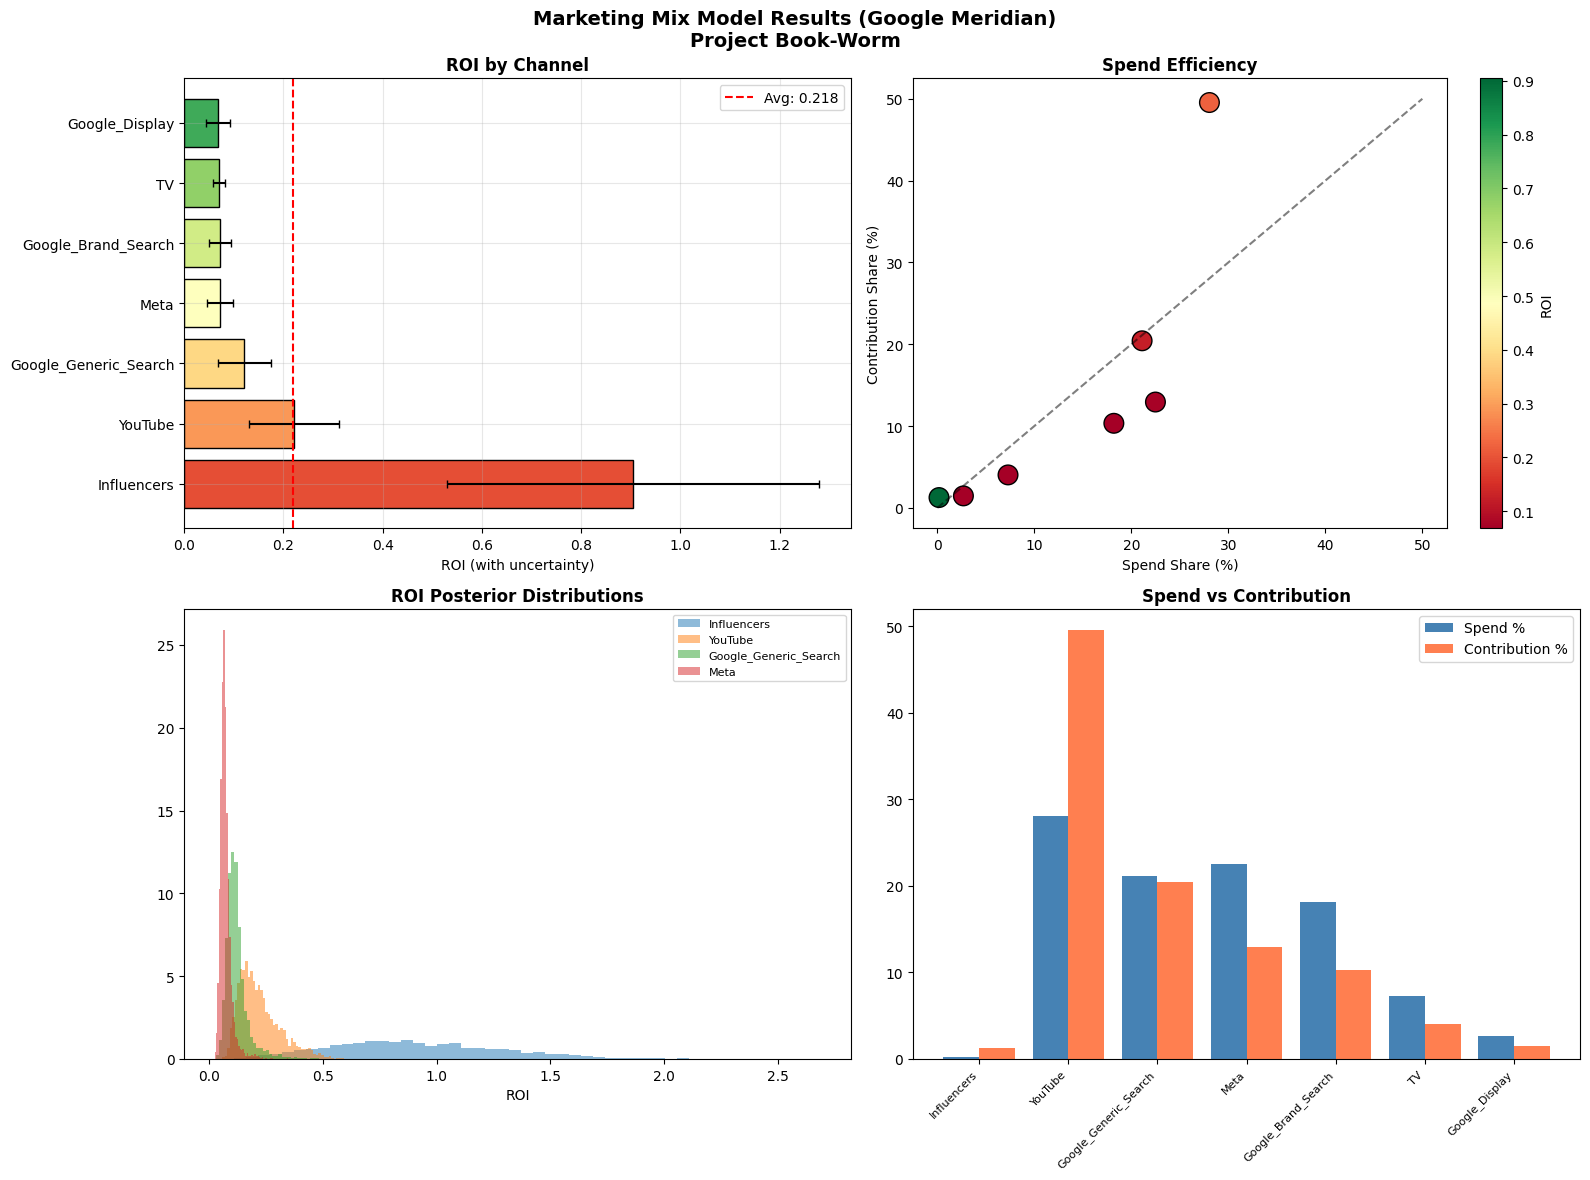

In [10]:
if __name__ == "__main__":
    mmm, results, recommendations = main()